## Exploration vs. Exploitation in Complex Environments

In reinforcement learning, particularly within the Multi-Armed Bandit (MAB) framework, the trade-off between exploration and exploitation is a fundamental dilemma. The agent must balance maximizing immediate rewards based on current knowledge with acquiring new information to make better decisions in the future.

### 1. Action-Value Estimation
To make informed decisions, the agent estimates the value (expected reward) of each action $a$, denoted as $Q_t(a)$, at time step $t$. This is typically calculated using the sample-average method. To compute this efficiently without storing all past rewards, we use the **incremental update rule**:

$$Q_{n+1} = Q_n + \frac{1}{n} (R_n - Q_n)$$

where $R_n$ is the $n$-th reward received for that action, and $n$ is the number of times the action has been selected. The term $(R_n - Q_n)$ acts as the temporal difference error.

### 2. Exploitation (Greedy Action)
* **Concept**: Selecting the action with the highest estimated value: $A_t = \arg\max_a Q_t(a)$.
* **Objective**: To maximize current short-term rewards.
* **Disadvantage**: Early estimates are highly prone to variance. Pure exploitation ($\epsilon = 0$) causes the algorithm to easily lock onto a "suboptimal action" that coincidentally yielded a high reward early on, leading to premature convergence and missing the true optimal action.

### 3. Exploration
* **Concept**: Forgoing the currently best-looking option to try random actions, regardless of their current value estimates.
* **Objective**: To gather more information, refine $Q$-value estimates, and discover truly high-reward actions in the long run.
* **Disadvantage**: Over-exploration (e.g., $\epsilon = 0.1$) means that even when the agent has confidently found the best action, it continues to waste 10% of its steps choosing blindly. This places an artificial ceiling on the maximum cumulative reward.

### 4. The Trade-off ($\epsilon$-greedy Strategy)
The $\epsilon$-greedy algorithm elegantly balances these two concepts. With probability $1 - \epsilon$, it exploits the best-known action; with probability $\epsilon$, it explores uniformly at random. 
In our experiments, $\epsilon = 0.01$ provides the optimal long-term balance. It spends 99% of its time greedily maximizing rewards and 1% of its time mitigating unknown risks. It resolves the premature convergence of pure greedy methods while avoiding the high regret penalty of over-exploration.

### 5. Multi-Dimensional Experimental Setup
To rigorously test this theory, the code below simulates MAB environments across two dimensions (averaging over 2000 independent runs for statistical significance):
* **Exploration Rates**: $\epsilon \in \{0, 0.01, 0.1\}$
* **Environmental Complexity**: $k \in \{5, 10, 20\}$ arms. As $k$ increases, the probability of finding the optimal arm by pure chance decreases, making active exploration vastly more critical.

We track two critical metrics:
1. **Average Reward**: The magnitude of reward the agent receives over time.
2. **% Optimal Action**: The frequency with which the agent successfully identifies and selects the absolute best arm.

Simulating k=5...
Simulating k=10...
Simulating k=20...
Comparison plot saved to: .\figure_problem2.png


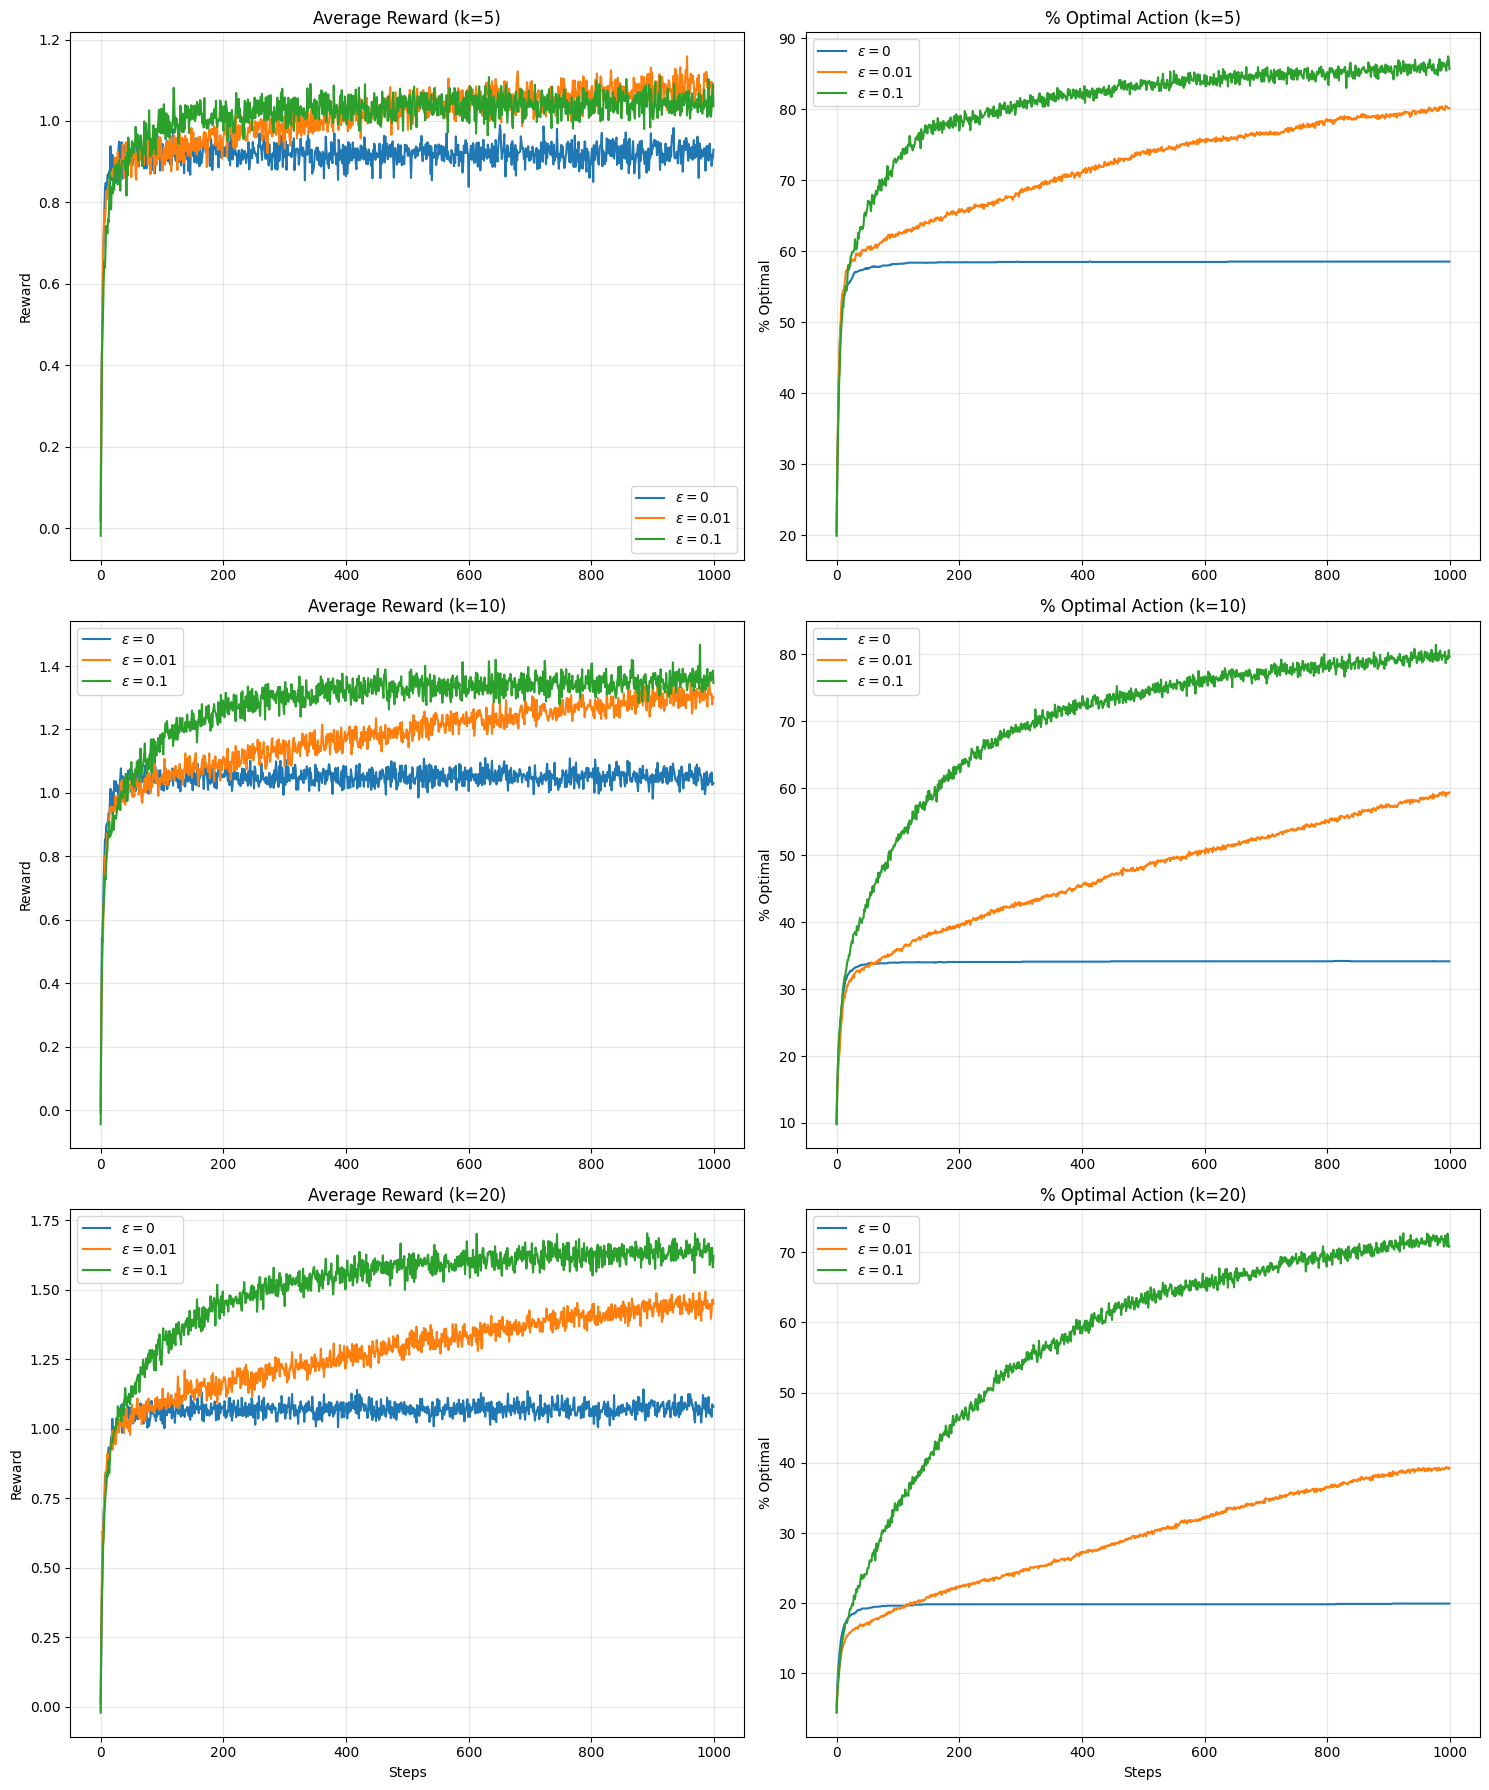

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Define the Multi-Armed Bandit Environment
class Bandit:
    def __init__(self, k):
        self.k = k
        # True reward means sampled from a standard normal distribution
        self.q_true = np.random.randn(k)
        # Identify the index of the absolute best action
        self.best_action = np.argmax(self.q_true)

    def step(self, action):
        # Return reward with noise: Mean = q_true, Variance = 1
        return np.random.randn() + self.q_true[action]

# 2. Simulation function for a specific epsilon and k
def run_simulation(epsilon, k, steps=1000, runs=2000):
    avg_rewards = np.zeros(steps)
    optimal_action_pct = np.zeros(steps)
    
    for _ in range(runs):
        b = Bandit(k)
        q_est = np.zeros(k)    # Q-value estimates initialized to zero
        counts = np.zeros(k)   # Action counters initialized to zero
        
        for s in range(steps):
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(k) # Exploration: Random choice
            else:
                # Exploitation: Greedy choice with random tie-breaking
                action = np.random.choice(np.where(q_est == np.max(q_est))[0])
            
            reward = b.step(action)
            
            # Incremental update rule for Action-Value Estimation
            counts[action] += 1
            q_est[action] += (reward - q_est[action]) / counts[action]
            
            # Accumulate metrics for averaging
            avg_rewards[s] += reward
            if action == b.best_action:
                optimal_action_pct[s] += 1
                
    # Return average reward and percentage of optimal action selection
    return avg_rewards / runs, (optimal_action_pct / runs) * 100

# 3. Execution and Visualization Configuration
eps_values = [0, 0.01, 0.1]
k_values = [5, 10, 20]
steps, runs = 1000, 2000

# Save to the current directory
folder_name = '.' 

print("Starting simulations. This may take a moment...")
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for i, k in enumerate(k_values):
    print(f"Simulating k={k} environment...")
    for eps in eps_values:
        rewards, optimal = run_simulation(eps, k, steps, runs)
        
        # Plot Average Reward (Left Column)
        axes[i, 0].plot(rewards, label=f'$\epsilon={eps}$')
        axes[i, 0].set_title(f'Average Reward (k={k})', fontsize=12)
        axes[i, 0].set_ylabel('Reward')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot % Optimal Action (Right Column)
        axes[i, 1].plot(optimal, label=f'$\epsilon={eps}$')
        axes[i, 1].set_title(f'% Optimal Action (k={k})', fontsize=12)
        axes[i, 1].set_ylabel('% Optimal')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

# Set common X-axis labels for the bottom row
axes[2, 0].set_xlabel('Steps', fontsize=12)
axes[2, 1].set_xlabel('Steps', fontsize=12)

plt.tight_layout()

# Save the resulting figure
save_path = os.path.join(folder_name, 'figure_problem2.png')
plt.savefig(save_path, dpi=300)
print(f"Comprehensive comparison plot saved to: {save_path}")

plt.show()

## Final Analysis: Synthesizing the Dilemma

![Performance Curves](figure_problem2.png)

The comparative grid generated above provides robust empirical evidence for the theoretical frameworks discussed in Section II. By observing the interaction between the exploration rate ($\epsilon$) and environmental complexity ($k$), we draw the following conclusions:

1. **The Trap of Pure Exploitation ($\epsilon = 0.0$)**:
   Across all scenarios, the pure greedy strategy (Blue line) plateaus very early. In simple $k=5$ environments, it has a moderate chance of stumbling upon the best arm. However, as complexity scales to $k=20$, its ability to find the optimal action collapses. Without exploration, the agent frequently locks onto a suboptimal arm that merely happened to yield a high initial reward, demonstrating severe premature convergence.

2. **The Ceiling of Over-Exploration ($\epsilon = 0.1$)**:
   A high exploration rate (Green line) allows the agent to discover the optimal action much faster in the early stages, which is especially noticeable in the crowded $k=20$ environment. However, its long-term performance is strictly capped. Because it is forced to select a completely random action 10% of the time, its "% Optimal Action" curve hits a hard ceiling (around 80-90%). It sacrifices too much long-term reward for unnecessary information gathering.

3. **The Optimal Trade-off ($\epsilon = 0.01$)**:
   This strategy (Orange line) perfectly illustrates the power of balanced exploration. While it learns slower than $\epsilon=0.1$ in the first few hundred steps (paying the "exploration tax" sparingly), it eventually surpasses it. By exploring just 1% of the time, it steadily uncovers the true optimal action across all scales ($k=5, 10, 20$) without placing an artificial ceiling on its late-game performance.

**Final Verdict**: 
The empirical results beautifully validate the theoretical dilemma. Environmental complexity ($k$) dictates the **difficulty of discovery**, making exploration strictly necessary. However, the chosen exploration rate ($\epsilon$) dictates the **precision of the final policy**. In a stationary Multi-Armed Bandit environment, a small, persistent exploration rate ($\epsilon = 0.01$) provides the optimal balance, preventing premature convergence while maximizing long-term cumulative rewards regardless of scale.